<a href="https://colab.research.google.com/github/odedgolden/AVEC2018/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
is_first_time = False

##Kaggle Integration

In [0]:
if is_first_time:
  from google.colab import files
  files.upload()

In [0]:
if is_first_time:
  !ls -lha kaggle.json

In [0]:
if is_first_time:
  !pip install -q kaggle

In [0]:
if is_first_time:
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json

In [0]:
if is_first_time:
  !kaggle competitions download -c quora-insincere-questions-classification -p /content/drive/My\ Drive/Colab\ Notebooks/Research/Quora

##Imports

In [8]:
# Basic Stuff
import numpy as np
import pandas as pd
from time import time, ctime
import random

# Basic Machine Learning Stuff
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import xgboost as xgb

# NLP Stuff
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

# Deep Learning Stuff
# import cv2
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn.parameter import Parameter
# from torch.utils.data import Dataset, DataLoader

# Visualization Stuff
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


# Drive Stuff
import urllib.request
import zipfile
import sys
import os
import pickle
import gc
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = '/content/drive/My Drive/Colab Notebooks/Research/Quora'

#Data Loading

##Prepare Files

In [0]:
def save_obj(obj, name ):
    with open(root + '/obj/' + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
  if os.path.isfile(root + 'obj/' + name + '.pkl'):
    with open(root + 'obj/' + name + '.pkl', 'rb') as f:
          return pickle.load(f)

In [0]:
if is_first_time:
  root_dir = os.listdir(root)
  root_dir

In [0]:
if is_first_time:
  for zip_file_name in root_dir:
    with zipfile.ZipFile(root+'/'+zip_file_name, 'r') as zip_ref:
      zip_ref.extractall(root)
      zip_ref.close()
    print('Extracted to: '+root)

In [0]:
if is_first_time:
  root_dir = os.listdir(root)
  root_dir

In [0]:
test_data = pd.read_csv(root+'/test.csv') 
sample_submission = pd.read_csv(root+'/sample_submission.csv') 

###1. qid - unique question identifier
###2. question_text - Quora question text
###3. target - a question labeled "insincere" has a value of 1, otherwise 0

Longesst Sentence Length: 412
Average Sentence Length: 14.44675688794768
Longesst Sentence: What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{

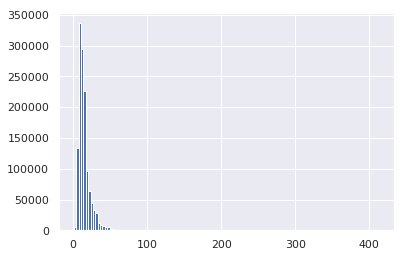

In [16]:
if not is_first_time:
  train_data = pd.read_csv(root+'/train.csv') 
  train_data['question_length'] = train_data.apply(lambda x: len(word_tokenize(x['question_text'])),axis=1)
  train_data.to_csv(root+'/train_data_with_length.csv')
else:
  train_data = pd.read_csv(root+'/train_data_with_length.csv') 

m = np.max(train_data['question_length'])
max_sentence = train_data.iloc[train_data['question_length'].idxmax()]['question_text']
avg = np.mean(train_data['question_length'])
print("Longesst Sentence Length: "+str(m))
print("Average Sentence Length: "+str(avg))
print("Longesst Sentence: "+str(max_sentence))
train_data['question_length'].hist(bins=128)

In [17]:
pd.set_option('max_colwidth', 128)
train_data.head(1)

,qid,question_text,target,question_length
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,14


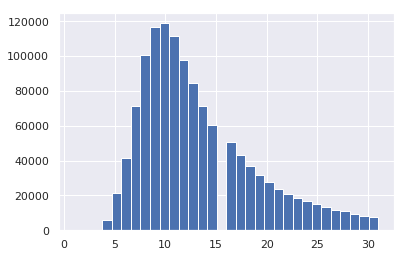

In [18]:
train_data[train_data['question_length']<32]['question_length'].hist(bins=32)

In [0]:
pos_data = train_data[train_data['target']==1]
neg_data = train_data[train_data['target']==0]

In [20]:
print("There are total of "+str(train_data.size)+" samples")
print("There are "+str(pos_data.size)+" positive samples (insincere)")
print("There are "+str(neg_data.size)+" negative samples (sincere)")
print("Ratio is: %.3f" % (pos_data.size/neg_data.size))

There are total of 5224488 samples
There are 323240 positive samples (insincere)
There are 4901248 negative samples (sincere)
Ratio is: 0.066


In [21]:
train_data_balanced = pd.concat([resample(neg_data,replace = False,n_samples = len(pos_data)), pos_data])
print("There are total of "+str(train_data_balanced.size)+" samples")
train_data_balanced.head(3)

There are total of 646480 samples


,qid,question_text,target,question_length
1173452,e5f504e064c1c956f33b,Where is the best course available for Python?,0,9
551798,6c1ba1c2588cb9bc04a1,Do you think it is fair to classify climate change denial as a conspiracy theory?,0,16
321927,3f16e72f2fe65efca357,Should I choose CS at JSS or it at knit. plz help me to choose?,0,17


## Embeddings

###Challenges:
1. Sentences are in different lengths
2. Sequence order does matter

In [21]:
# glove2word2vec(glove_input_file=root+'/glove.840B.300d/glove.840B.300d.txt', word2vec_output_file=root+"/gensim_glove_vectors.txt")    
glove_model = KeyedVectors.load_word2vec_format(root+"/gensim_glove_vectors.txt", binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [22]:
glove_model["Hello"].shape

(300,)

In [46]:
X,y = train_data_balanced.iloc[:,:2],train_data_balanced.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
number_of_samples = 50000
updated_train_data_resampled = pd.concat([X_train, y_train],axis=1)
train_data_balanced_resampled = resample(updated_train_data_resampled,replace = False,n_samples = number_of_samples)
X_train_resampled, y_train_resampled = train_data_balanced_resampled.iloc[:,:2],train_data_balanced_resampled.iloc[:,2]
chosen_question_length = 32
word_vector_size = 300
X_train_resampled.shape

(50000, 2)

In [0]:
def vectorize(X,chosen_question_length,word_vector_size):
  X_vectorized = np.empty((X.shape[0],chosen_question_length,word_vector_size))
  for i in range(X.shape[0]):
    current_sentence = word_tokenize(X.iloc[i]['question_text'])
    for j in range(chosen_question_length):
      if j<len(current_sentence) and current_sentence[j] in glove_model:
        X_vectorized[i,j] = glove_model[current_sentence[j]]
      else:
        X_vectorized[i,j] = np.zeros((300,))
    if i % 10000 ==0:
      print(i,end ="-")
  return X_vectorized

In [48]:
if not is_first_time:
  X_train_resampled = vectorize(X_train_resampled,chosen_question_length,word_vector_size)
  save_obj(X_train_resampled, 'X_train_resampled')
else:
  X_train_resampled = load_obj('X_train_resampled')
X_train_resampled.shape
X_test = vectorize(X_test,chosen_question_length,word_vector_size)

->->->->->->->->->

In [0]:
nsamples, nx, ny = X_train_resampled.shape
X_train_resampled_2d = X_train_resampled.reshape((nsamples,nx*ny))
del X_train_resampled

In [50]:
X_train_resampled_2d.shape

(50000, 9600)

In [51]:
if is_first_time:
  clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_resampled_2d, y_train_resampled)
  save_obj(clf, 'LR' )
else:
  clf = load_obj('LR')
print(clf)
# gnb = GaussianNB().fit(X_train_resampled_2d, y)
# save_obj(gnb, 'GNB' )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [59]:
if not is_first_time:
  gnb = GaussianNB().fit(X_train_resampled_2d, y_train_resampled)
  save_obj(gnb, 'GNB' )
else:
  gnb = load_obj('GNB')
print(gnb)

GaussianNB(priors=None, var_smoothing=1e-09)


In [0]:
if not is_first_time:
  gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train_resampled_2d, y_train_resampled)
  save_obj(gbm, 'GBM' )
else:
  gbm = load_obj('GBM')
print(gbm)

In [0]:
nsamples, nx, ny = X_test.shape
X_test_2d = X_test.reshape((nsamples,nx*ny))
del X_test

In [60]:
print('Gaussian Naive Baise Score: ', gnb.score(X_test_2d, y_test))

Gaussian Naive Baise Score:  0.6176215814874396


In [0]:
print('Logistic Regression Score: ', clf.score(X_test_2d, y_test))

In [1]:
print('XGBoost Score: ', gbm.score(X_test_2d, y_test))

NameError: ignored

In [0]:
def predict(clf,sentnce):
  X_vectorized = np.empty((1,chosen_question_length,word_vector_size))
  current_sentence = word_tokenize(sentnce)
  for j in range(chosen_question_length):
    if j<len(current_sentence) and current_sentence[j] in glove_model:
      X_vectorized[0,j] = glove_model[current_sentence[j]]
    else:
      X_vectorized[0,j] = np.zeros((300,))
  return clf.predict(X_vectorized.reshape(1,chosen_question_length*word_vector_size))

In [57]:
lets_have_fun = ["What is wrong with fat ass?","What is love?","What is wrong with fat milk?","Do Arabs eat humus?","Do aliens exist?"]

for s in lets_have_fun:
  result = predict(clf,s)
  print(s+'\t is '+ ('insincere' if predict(clf,s)[0] else 'sincere'))

What is wrong with fat ass?	 is insincere
What is love?	 is sincere
What is wrong with fat milk?	 is insincere
Do Arabs eat humus?	 is insincere
Do aliens exist?	 is sincere
